Determine who would have survived the titanic sinking<br>
Problem: Binary classification

# Get Data

In [105]:
import pandas as pd
titanic_train = pd.read_csv("/content/train.csv", index_col="PassengerId")
titanic_test = pd.read_csv("/content/test.csv", index_col="PassengerId")
test_data = pd.read_csv("/content/test.csv")

In [3]:
titanic_train.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# Get categorical and numerical columns
cat_cols = [col for col in titanic_train.columns if titanic_train[col].dtype == 'object']
num_cols = [col for col in titanic_train.columns if col not in cat_cols ]
num_cols

['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [6]:
# check which columns have NaN values
cols_with_nan = titanic_train.columns[titanic_train.isna().any()].tolist()
cols_with_nan

['Age', 'Cabin', 'Embarked']

In [7]:
nan_count = []
for col in cols_with_nan:
  count = titanic_train[col].isna().sum()
  nan_count.append(count)
nan_count

[177, 687, 2]

In [8]:
# Check train data shape
titanic_train.shape

(891, 11)

In [48]:
titanic_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [49]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Age, Embarked, Cabin(77%) have non-null values <br>
Observe some of the classes

In [50]:
titanic_train["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [51]:
titanic_train["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [52]:
titanic_train["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [53]:
titanic_train["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

C = Cherbourg, Q = Queenstown, S = Southampton

In [54]:
# Preprocessor Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
  def __init__(self, attribute_names):
    self.attribute_names = attribute_names
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    return X[self.attribute_names]

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
                         ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
                         ("imputer", SimpleImputer(strategy="median")),
])

In [58]:
num_pipeline.fit_transform(titanic_train)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

In [59]:
# Transformer for imputing missing values in our categorical columns
class MostFrequentImputer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X], index=X.columns)
    return self
  def transform(self, X, y=None):
    return X.fillna(self.most_frequent_)

In [60]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
                         ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
                         ("imputer", MostFrequentImputer()),
                         ("cat_encoder", OneHotEncoder(sparse=False)),
])
cat_pipeline.fit_transform(titanic_train)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [61]:
# Join both pipelines
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
                                                     ("num_pipeline", num_pipeline),
                                                     ("cat_pipeline", cat_pipeline),
])

In [62]:
# Preprocess data
X_train = preprocess_pipeline.fit_transform(titanic_train)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [63]:
y_train = titanic_train["Survived"]

### Train binary classifiers
<ol>
  <li>SVC</li>
  <li>RandomForestClassifier</li>
  <li>KNN</li>
</ol>

In [64]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [65]:
# Check performance
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7329588014981274

In [66]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8126466916354558

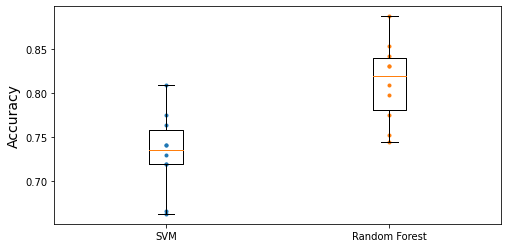

In [67]:
# Plot boxplots
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

In [69]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=4, weights='distance')
knn_scores = cross_val_score(knn_clf, X_train, y_train, cv=10)
knn_scores.mean()

0.7239450686641697

In [91]:
import random
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

def rnd_nums():
  num_list = [] 
  for i in range(0, 5):
    n = random.randint(0, 200)
    num_list.append(n)
  return num_list

param_grid = [
              {
                  'hidden_layer_sizes': rnd_nums()
              }
]

mpl_classifier = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=9)
rnd_search = RandomizedSearchCV(mpl_classifier, param_grid, cv=5, verbose=3)
rnd_search.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] hidden_layer_sizes=95 ...........................................


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] ............... hidden_layer_sizes=95, score=0.816, total=   0.8s
[CV] hidden_layer_sizes=95 ...........................................
[CV] ............... hidden_layer_sizes=95, score=0.815, total=   0.8s
[CV] hidden_layer_sizes=95 ...........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ............... hidden_layer_sizes=95, score=0.781, total=   0.8s
[CV] hidden_layer_sizes=95 ...........................................


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ............... hidden_layer_sizes=95, score=0.792, total=   0.8s
[CV] hidden_layer_sizes=95 ...........................................
[CV] ............... hidden_layer_sizes=95, score=0.837, total=   0.7s
[CV] hidden_layer_sizes=166 ..........................................


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .............. hidden_layer_sizes=166, score=0.760, total=   1.2s
[CV] hidden_layer_sizes=166 ..........................................


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .............. hidden_layer_sizes=166, score=0.820, total=   1.2s
[CV] hidden_layer_sizes=166 ..........................................


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .............. hidden_layer_sizes=166, score=0.792, total=   1.2s
[CV] hidden_layer_sizes=166 ..........................................


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .............. hidden_layer_sizes=166, score=0.792, total=   1.2s
[CV] hidden_layer_sizes=166 ..........................................
[CV] .............. hidden_layer_sizes=166, score=0.831, total=   0.9s
[CV] hidden_layer_sizes=9 ............................................


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ................ hidden_layer_sizes=9, score=0.749, total=   0.3s
[CV] hidden_layer_sizes=9 ............................................


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ................ hidden_layer_sizes=9, score=0.719, total=   0.3s
[CV] hidden_layer_sizes=9 ............................................


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ................ hidden_layer_sizes=9, score=0.792, total=   0.3s
[CV] hidden_layer_sizes=9 ............................................


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ................ hidden_layer_sizes=9, score=0.798, total=   0.3s
[CV] hidden_layer_sizes=9 ............................................


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ................ hidden_layer_sizes=9, score=0.815, total=   0.3s
[CV] hidden_layer_sizes=200 ..........................................
[CV] .............. hidden_layer_sizes=200, score=0.810, total=   0.9s
[CV] hidden_layer_sizes=200 ..........................................


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .............. hidden_layer_sizes=200, score=0.798, total=   1.4s
[CV] hidden_layer_sizes=200 ..........................................


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .............. hidden_layer_sizes=200, score=0.803, total=   1.4s
[CV] hidden_layer_sizes=200 ..........................................


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] .............. hidden_layer_sizes=200, score=0.787, total=   1.4s
[CV] hidden_layer_sizes=200 ..........................................
[CV] .............. hidden_layer_sizes=200, score=0.831, total=   1.1s
[CV] hidden_layer_sizes=64 ...........................................


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ............... hidden_layer_sizes=64, score=0.782, total=   0.7s
[CV] hidden_layer_sizes=64 ...........................................


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ............... hidden_layer_sizes=64, score=0.809, total=   0.7s
[CV] hidden_layer_sizes=64 ...........................................


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ............... hidden_layer_sizes=64, score=0.787, total=   0.7s
[CV] hidden_layer_sizes=64 ...........................................


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV] ............... hidden_layer_sizes=64, score=0.787, total=   0.7s
[CV] hidden_layer_sizes=64 ...........................................


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   21.0s finished


[CV] ............... hidden_layer_sizes=64, score=0.826, total=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                           batch_size='auto', beta_1=0.9,
                                           beta_2=0.999, early_stopping=False,
                                           epsilon=1e-08, hidden_layer_sizes=9,
                                           learning_rate='adaptive',
                                           learning_rate_init=0.001,
                                           max_fun=15000, max_iter=200,
                                           momentum=0.9, n_iter_no_change=10,
                                           nesterovs_momentum=True, power_t=0.5,
                                           random_state=None, shuffle=True,
                                           solver='adam', tol=0.0001,
                                           validation_fraction=0.1,
                                           verbose=False, warm_sta

In [92]:
rnd_search.best_params_

{'hidden_layer_sizes': 95}

In [93]:
rnd_search.best_score_

0.808072311844831

In [84]:
# Combine different numerical attributes into different categorical attributes
titanic_train["AgeBucket"] = titanic_train["Age"] // 15 * 15
titanic_train[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [86]:
titanic_train["RelativesOnboard"] = titanic_train["SibSp"] + titanic_train["Parch"]
titanic_train[["RelativesOnboard", "Survived"]].groupby(["RelativesOnboard"]).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


In [94]:
X_train = preprocess_pipeline.fit_transform(titanic_train)
mlp_v2 = MLPClassifier(**rnd_search.best_params_)
mlp_v2_scores = cross_val_score(mlp_v2, X_train, y_train)
mlp_v2_scores.mean()

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.7991337643587972

In [95]:
rnd_forest_v2 = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores_v2 = cross_val_score(rnd_forest_v2, X_train, y_train, cv=10)

In [96]:
forest_scores_v2.mean()

0.8126466916354558

In [98]:
rnd_forest_v2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [109]:
# Add new columns
titanic_test["RelativesOnboard"] = titanic_test["SibSp"] + titanic_test["Parch"]
titanic_test["AgeBucket"] = titanic_test["Age"] // 15 * 15

X_test = preprocess_pipeline.transform(titanic_test)
y_pred = rnd_forest_v2.predict(X_test)

In [118]:
y_pred

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [110]:
len(X_test)

418

In [ ]:
# Create csv file
import csv
j=0
with open("/content/results.csv", 'w') as csvfile:
  filewriter = csv.writer(csvfile, delimiter=",", quotechar="|", quoting=csv.QUOTE_MINIMAL)
  for i, row in titanic_test.iterrows():
    print(i)
    filewriter.writerow([i, y_pred[j]])
    j += 1

In [112]:
titanic_test.head(5)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,RelativesOnboard,AgeBucket
PassengerId,,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,30.0
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1,45.0
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,60.0
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,15.0
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,2,15.0
